In [1]:
import timm
import torch
import torch as t
import torch.nn as nn
import torchvision
import torch.optim as optim

from tqdm import tqdm

import matplotlib.pyplot as plt

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Vision Model

In [3]:
# Load a pre-trained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Move the model to GPU if available
model = model.to(device)

# Data

In [4]:
# Load in Preprocessing
from timm.data.transforms_factory import create_transform
from timm.data import resolve_data_config

config = resolve_data_config(model.default_cfg)
transform = create_transform(**config)

In [5]:
def get_ImageNet(transforms = None, batch_size = 1, shuffle = False):
  ImageNet_path = '/imagenet'
  dataset = torchvision.datasets.ImageNet(ImageNet_path, split = 'val', transform = transforms)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)
  return dataset, dataloader

dataset, dataloader = get_ImageNet(transforms = transform, batch_size = 1, shuffle = True)

In [6]:
input_tensor = torch.stack([dataset[50 * i - 1][0] for i in range(100)])
input_tensor.shape

torch.Size([100, 3, 224, 224])

# Distortions

In [7]:
from diffeo import apply_transformation, sin_distortion

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9895847..1.0].


Diffeo Strength:  0.14177446067333221
torch.Size([2, 100, 3, 224, 224])


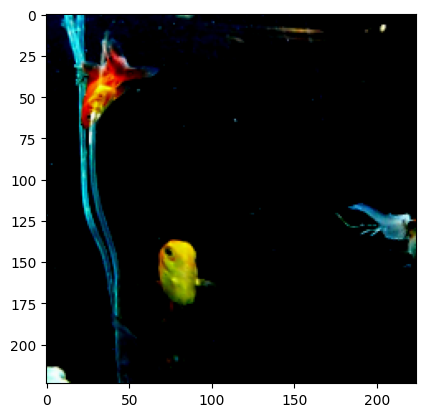

In [8]:
A_nm = torch.tensor([[0.0, 0.14],
                     [-0.02, 0.01]])
print('Diffeo Strength: ', float(A_nm.norm()))

input_tensor_diffeoed = [apply_transformation(tensor, A_nm) for tensor in input_tensor]
input_tensor_diffeoed = torch.stack(input_tensor_diffeoed)

input_batch = torch.stack([input_tensor, input_tensor_diffeoed], dim=0)

shape_categories = input_batch.shape[0]
shape_images = input_batch.shape[1]
shape_channel = input_batch.shape[2]
shape_pixels = input_batch.shape[3]

print(input_batch.shape)
plt.imshow(input_tensor_diffeoed[2].permute(1, 2, 0))

In [9]:
class add_bias_to_grid(torch.nn.Module):
  def __init__(self, grid):
    # grid should have the shape of a grid_sample grid, i.e. (Channel, X, Y, 2)
    super().__init__()
    self.grid = grid
    self.bias = torch.nn.Parameter(torch.zeros_like(grid[:,1:-1,1:-1,:]))
  def forward(self):
    return self.grid + torch.nn.functional.pad(self.bias, (0,0,1,1,1,1), "constant", 0)

def find_inv_grid(flow_grid, mode ='bilinear', learning_rate = 0.001, epochs = 10000, early_stopping = True):
  batch, x_length, y_length, _ = flow_grid.shape
  x = torch.linspace(-1, 1, steps = x_length)
  y = torch.linspace(-1, 1, steps = y_length)
  X, Y = torch.meshgrid(x, y, indexing='ij')
  reference = torch.stack((X, Y, X * Y), dim=0).unsqueeze(0).repeat(batch, 1, 1, 1)
  #, torch.cos(2*math.pi*X) * torch.cos(2*math.pi*Y)
  id_grid = torch.stack((Y, X), dim=-1).unsqueeze(0).repeat(batch, 1, 1, 1)
  #2 * id_grid - flow_grid
  find_inv_model = add_bias_to_grid(id_grid)
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(find_inv_model.parameters(), lr = learning_rate)

  num_epochs = epochs
  loss_hist = []
  min_loss = 1e30
  early_stopping_count = 0
  for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    output = find_inv_model()
    distort = torch.nn.functional.grid_sample(reference, flow_grid, mode = mode)
    #inv_distort = torch.nn.functional.grid_sample(reference, output, mode = mode)
    restored_left  = torch.nn.functional.grid_sample(distort, output, mode = mode)
    #restored_right = torch.nn.functional.grid_sample(inv_distort, flow_grid, mode = mode)
    left_loss = loss_fn(reference, restored_left)
    #right_loss = loss_fn(reference, restored_right)
    loss = left_loss #+ right_loss #+ (torch.exp(torch.abs(left_loss-right_loss)**2) - 1)
    #loss =  left_loss + right_loss
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
          loss_hist.append(loss.item())
          if loss_hist[-1]/min_loss >= 1:
            early_stopping_count += 1
            print(f'Early stopping count: {early_stopping_count}')
          if loss_hist[-1] < min_loss:
            min_loss = loss_hist[-1]
            early_stopping_count = 0
    if early_stopping and early_stopping_count >=7:
      print('Finished!')
      break

  with torch.no_grad():
    flow_grid_inverse_neural = find_inv_model().detach().clone()

  return flow_grid_inverse_neural, loss_hist

  0%|          | 0/10000 [00:00<?, ?it/s]/ext3/miniforge3/lib/python3.12/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
  2%|▏         | 159/10000 [00:00<00:06, 1475.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9842641..0.9963896].


Early stopping count: 1
Early stopping count: 2
Early stopping count: 3
Early stopping count: 4
Early stopping count: 5
Early stopping count: 6
Early stopping count: 7
Finished!


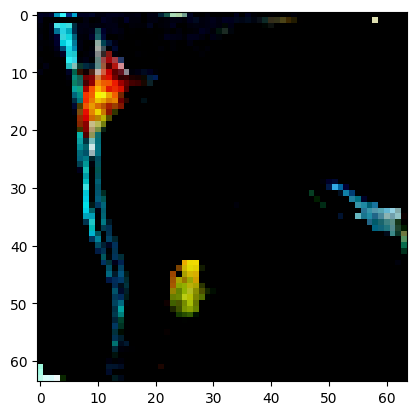

In [10]:
x_length, y_length = 64, 64
x_map, y_map = sin_distortion(x_length, y_length, A_nm)

flow_grid = torch.stack((y_map, x_map), dim=-1)
flow_grid = flow_grid.unsqueeze(0)

flow_gridInverse, _ = find_inv_grid(flow_grid, learning_rate=1000)

image_tensor_undeformed = torch.nn.functional.grid_sample(input_tensor_diffeoed[2].unsqueeze(0),
                                                          flow_gridInverse,
                                                          align_corners=True)
plt.imshow(
    image_tensor_undeformed.squeeze(0).permute(1, 2, 0)
    )

# Experiment

## Get Latent Layers

In [11]:
def get_activation(model, input, layer_index: list):

  activation = {}
  def getActivation(name):
      # the hook signature
      def hook(model, input, output):
          activation[name] = output.detach()
      return hook

  handles = []
  def retrieve_layer_activation(model, input, layer_index):
    if len(input) == 3: input = input[None, :, :, :]

    layers = list(model.children())
    layers_flat = flatten(layers)

    for index in layer_index:
      handles.append(layers_flat[index - 1].register_forward_hook(getActivation(str(index))))

    with t.no_grad(): model(input)
    for handle in handles: handle.remove()

    return

  def flatten(array):
      result = []
      for element in array:
          if hasattr(element, "__iter__"):
              result.extend(flatten(element))
          else:
              result.append(element)
      return result

  retrieve_layer_activation(model, input, layer_index)
  return activation

In [12]:
layer_id = 13

# Move the input and model to the appropriate device (e.g., GPU if available)
device = t.device("cuda" if t.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)
model.to(device)

# Get the activation of a specific layer
input_batch = input_batch.reshape(shape_categories * shape_images, shape_channel, shape_pixels, shape_pixels)

In [13]:
activations = get_activation(model, input_batch, [layer_id])[f'{layer_id}']
activations = activations.reshape(shape_categories, shape_images, *activations.shape[1:]).to(device)

original_activation = activations[0]
diffeo_activation = activations[1]

activations.shape, original_activation.shape, diffeo_activation.shape

(torch.Size([2, 100, 197, 768]),
 torch.Size([100, 197, 768]),
 torch.Size([100, 197, 768]))

In [14]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 86567656


## Regression Model 

In [15]:
class Autoencoder(nn.Module):
  def __init__(self, flow_grid, dtype=torch.float32):
    super(Autoencoder, self).__init__()

    # Parameters for model
    self.flow_grid = flow_grid
    input_size = 197 * 768
    self.image_length = 64
    self.compression_size = self.image_length**2

    # Model
    self.encoder = nn.Sequential(
        nn.Linear(input_size, self.compression_size),
    )
    self.decoder = nn.Sequential(
        nn.Linear(self.compression_size, input_size),
    )
    self.to(dtype)

  def forward(self, x):
    batch_size = x.size(0)

    # Encoder
    x = self.encoder(x)

    # g^{-1}_{naive}
    x = x.reshape(batch_size, 1, self.image_length, self.image_length) # b&w image
    # x = x.reshape(x.shape[0], 1, self.image_length, self.image_length) # color image
    flow_grid_expanded = self.flow_grid.expand(batch_size, -1, -1, -1)  # Expand to match batch size
    x = torch.nn.functional.grid_sample(x,
                                        flow_grid_expanded,
                                        align_corners=True)
    x = x.reshape(batch_size, self.compression_size)

    # Decoder
    x = self.decoder(x)
    return x

## Train

In [16]:
# Model
dtype = torch.float32

flow_gridInverse = flow_gridInverse.to(device)

autoencoder = Autoencoder(flow_grid=flow_gridInverse, dtype=dtype)
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=151296, out_features=4096, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4096, out_features=151296, bias=True)
  )
)

In [17]:
criterion = nn.MSELoss()  # Example loss function

X = diffeo_activation.view(diffeo_activation.size(0), -1).to(dtype)
y = original_activation.view(original_activation.size(0), -1).to(dtype)

print('Baseline', float(criterion(X,y)))

Baseline 0.7234963178634644


In [18]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 1

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [22]:
def gradient_norm(model, norm_type=2):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.norm(norm_type)
            total_norm += param_norm.item() ** norm_type
    return total_norm ** (1.0 / norm_type)  # Compute the final norm

In [34]:
optimizer = optim.SGD(autoencoder.parameters(), lr=1e-6)

epochs = 1000
for epoch in tqdm(range(epochs)):
    model.train()
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        output = autoencoder(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    grad_norm = gradient_norm(model)
    print('Grad Norm', grad_norm)
    print('Loss', loss.item())  # Ensure you print the scalar value

  0%|          | 0/1000 [00:00<?, ?it/s]

Grad Norm 0.0


  0%|          | 1/1000 [00:03<55:08,  3.31s/it]

Loss 0.8281074166297913
Grad Norm 0.0


  0%|          | 2/1000 [00:06<55:04,  3.31s/it]

Loss 0.8985432386398315
Grad Norm 0.0


  0%|          | 3/1000 [00:09<55:00,  3.31s/it]

Loss 0.893784761428833
Grad Norm 0.0


  0%|          | 4/1000 [00:13<54:57,  3.31s/it]

Loss 0.7708393931388855
Grad Norm 0.0


  0%|          | 5/1000 [00:16<54:54,  3.31s/it]

Loss 0.9064025282859802
Grad Norm 0.0


  1%|          | 6/1000 [00:19<54:50,  3.31s/it]

Loss 0.827397882938385
Grad Norm 0.0


  1%|          | 7/1000 [00:23<54:47,  3.31s/it]

Loss 0.9308109283447266
Grad Norm 0.0


  1%|          | 8/1000 [00:26<54:44,  3.31s/it]

Loss 0.9064022898674011
Grad Norm 0.0


  1%|          | 9/1000 [00:29<54:40,  3.31s/it]

Loss 0.881846010684967
Grad Norm 0.0


  1%|          | 10/1000 [00:33<54:37,  3.31s/it]

Loss 0.7935891151428223
Grad Norm 0.0


  1%|          | 11/1000 [00:36<54:34,  3.31s/it]

Loss 0.9348646998405457
Grad Norm 0.0


  1%|          | 12/1000 [00:39<54:30,  3.31s/it]

Loss 0.9740312099456787
Grad Norm 0.0


  1%|▏         | 13/1000 [00:43<54:27,  3.31s/it]

Loss 0.8985424041748047
Grad Norm 0.0


  1%|▏         | 14/1000 [00:46<54:24,  3.31s/it]

Loss 0.9154112339019775
Grad Norm 0.0


  2%|▏         | 15/1000 [00:49<54:21,  3.31s/it]

Loss 0.8001551628112793
Grad Norm 0.0


  2%|▏         | 16/1000 [00:52<54:17,  3.31s/it]

Loss 0.7958672046661377
Grad Norm 0.0


  2%|▏         | 17/1000 [00:56<54:14,  3.31s/it]

Loss 0.9154110550880432
Grad Norm 0.0


  2%|▏         | 18/1000 [00:59<54:11,  3.31s/it]

Loss 0.887718915939331
Grad Norm 0.0


  2%|▏         | 19/1000 [01:02<54:07,  3.31s/it]

Loss 0.752263069152832
Grad Norm 0.0


  2%|▏         | 20/1000 [01:06<54:04,  3.31s/it]

Loss 0.8649892807006836
Grad Norm 0.0


  2%|▏         | 21/1000 [01:09<54:01,  3.31s/it]

Loss 0.8588055968284607
Grad Norm 0.0


  2%|▏         | 22/1000 [01:12<53:57,  3.31s/it]

Loss 0.8194716572761536
Grad Norm 0.0


  2%|▏         | 23/1000 [01:16<53:54,  3.31s/it]

Loss 0.736542284488678
Grad Norm 0.0


  2%|▏         | 24/1000 [01:19<53:51,  3.31s/it]

Loss 0.8877185583114624
Grad Norm 0.0


  2%|▎         | 25/1000 [01:22<53:47,  3.31s/it]

Loss 0.8145715594291687
Grad Norm 0.0


  3%|▎         | 26/1000 [01:26<53:44,  3.31s/it]

Loss 1.0025583505630493
Grad Norm 0.0


  3%|▎         | 27/1000 [01:29<53:41,  3.31s/it]

Loss 0.815471351146698
Grad Norm 0.0


  3%|▎         | 28/1000 [01:32<53:37,  3.31s/it]

Loss 0.8144868612289429
Grad Norm 0.0


  3%|▎         | 29/1000 [01:36<53:34,  3.31s/it]

Loss 0.7837644815444946
Grad Norm 0.0


  3%|▎         | 30/1000 [01:39<53:31,  3.31s/it]

Loss 0.9060075879096985
Grad Norm 0.0


  3%|▎         | 31/1000 [01:42<53:28,  3.31s/it]

Loss 0.7708376049995422
Grad Norm 0.0


  3%|▎         | 32/1000 [01:45<53:24,  3.31s/it]

Loss 0.8118466138839722
Grad Norm 0.0


  3%|▎         | 33/1000 [01:49<53:21,  3.31s/it]

Loss 0.7758515477180481
Grad Norm 0.0


  3%|▎         | 34/1000 [01:52<53:18,  3.31s/it]

Loss 0.8194708228111267
Grad Norm 0.0


  4%|▎         | 35/1000 [01:55<53:14,  3.31s/it]

Loss 0.9642014503479004
Grad Norm 0.0


  4%|▎         | 36/1000 [01:59<53:11,  3.31s/it]

Loss 0.8593108654022217
Grad Norm 0.0


  4%|▎         | 37/1000 [02:02<53:08,  3.31s/it]

Loss 0.8196184635162354
Grad Norm 0.0


  4%|▍         | 38/1000 [02:05<53:04,  3.31s/it]

Loss 0.7944662570953369
Grad Norm 0.0


  4%|▍         | 39/1000 [02:09<53:01,  3.31s/it]

Loss 0.9195939302444458
Grad Norm 0.0


  4%|▍         | 40/1000 [02:12<52:58,  3.31s/it]

Loss 0.7522618770599365
Grad Norm 0.0


  4%|▍         | 41/1000 [02:15<52:55,  3.31s/it]

Loss 0.7365411520004272
Grad Norm 0.0


  4%|▍         | 42/1000 [02:19<52:51,  3.31s/it]

Loss 0.9187865853309631
Grad Norm 0.0


  4%|▍         | 43/1000 [02:22<52:48,  3.31s/it]

Loss 0.9068804979324341
Grad Norm 0.0


  4%|▍         | 44/1000 [02:25<52:45,  3.31s/it]

Loss 0.9154089689254761
Grad Norm 0.0


  4%|▍         | 45/1000 [02:28<52:41,  3.31s/it]

Loss 0.8721728324890137
Grad Norm 0.0


  5%|▍         | 46/1000 [02:32<52:38,  3.31s/it]

Loss 0.9028838276863098
Grad Norm 0.0


  5%|▍         | 47/1000 [02:35<52:35,  3.31s/it]

Loss 0.9009443521499634
Grad Norm 0.0


  5%|▍         | 48/1000 [02:38<52:31,  3.31s/it]

Loss 0.8588669896125793
Grad Norm 0.0


  5%|▍         | 49/1000 [02:42<52:28,  3.31s/it]

Loss 0.8842207193374634
Grad Norm 0.0


  5%|▌         | 50/1000 [02:45<52:25,  3.31s/it]

Loss 0.8782820701599121
Grad Norm 0.0


  5%|▌         | 51/1000 [02:48<52:21,  3.31s/it]

Loss 0.9308078289031982
Grad Norm 0.0


  5%|▌         | 52/1000 [02:52<52:18,  3.31s/it]

Loss 0.7708362340927124
Grad Norm 0.0


  5%|▌         | 53/1000 [02:55<52:15,  3.31s/it]

Loss 0.7708361744880676
Grad Norm 0.0


  5%|▌         | 54/1000 [02:58<52:11,  3.31s/it]

Loss 0.81157386302948
Grad Norm 0.0


  6%|▌         | 55/1000 [03:02<52:08,  3.31s/it]

Loss 0.8509038090705872
Grad Norm 0.0


  6%|▌         | 56/1000 [03:05<52:05,  3.31s/it]

Loss 0.8614981770515442
Grad Norm 0.0


  6%|▌         | 57/1000 [03:08<52:02,  3.31s/it]

Loss 0.9686716794967651
Grad Norm 0.0


  6%|▌         | 58/1000 [03:12<51:58,  3.31s/it]

Loss 0.8812851309776306
Grad Norm 0.0


  6%|▌         | 59/1000 [03:15<51:58,  3.31s/it]

Loss 0.8812850713729858


KeyboardInterrupt: 